# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
import pickle

# Importing the Data

In [2]:
df = pd.read_parquet('data/preprocessed/forecast_ready.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379873 entries, 0 to 379872
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   unique_id              379873 non-null  object        
 1   sku_id                 379873 non-null  object        
 2   country                379873 non-null  object        
 3   ds                     379873 non-null  datetime64[ns]
 4   quantity               379873 non-null  float64       
 5   gmv                    379873 non-null  float64       
 6   total_order            379873 non-null  float64       
 7   total_customer         379873 non-null  float64       
 8   price                  379873 non-null  float64       
 9   missing_quantity       379873 non-null  bool          
 10  quantity_count         379873 non-null  int64         
 11  quantity_mean          379873 non-null  float64       
 12  quantity_median        379873 non-null  floa

In [4]:
df.head()

,unique_id,sku_id,country,ds,quantity,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
0,10002 | AUSTRALIA,10002,AUSTRALIA,2010-03-01,12.0,10.2,1.0,1.0,0.85,False,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
1,10002 | AUSTRALIA,10002,AUSTRALIA,2010-04-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
2,10002 | AUSTRALIA,10002,AUSTRALIA,2010-05-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
3,10002 | AUSTRALIA,10002,AUSTRALIA,2010-06-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
4,10002 | AUSTRALIA,10002,AUSTRALIA,2010-07-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664


In [5]:
df.ds.unique()

<DatetimeArray>
['2010-03-01 00:00:00', '2010-04-01 00:00:00', '2010-05-01 00:00:00',
 '2010-06-01 00:00:00', '2010-07-01 00:00:00', '2010-08-01 00:00:00',
 '2010-09-01 00:00:00', '2010-10-01 00:00:00', '2010-11-01 00:00:00',
 '2010-12-01 00:00:00', '2011-01-01 00:00:00', '2011-02-01 00:00:00',
 '2011-03-01 00:00:00', '2011-04-01 00:00:00', '2011-05-01 00:00:00',
 '2011-06-01 00:00:00', '2011-07-01 00:00:00', '2011-08-01 00:00:00',
 '2011-09-01 00:00:00', '2011-10-01 00:00:00', '2011-11-01 00:00:00',
 '2010-01-01 00:00:00', '2010-02-01 00:00:00', '2009-12-01 00:00:00']
Length: 24, dtype: datetime64[ns]

# Take Pareto Products

In [ ]:
def pareto_by_group(df, group_col, item_col, value_col, threshold=0.8):
    out = (df.groupby([group_col, item_col], as_index=False)[value_col].sum()
             .rename(columns={value_col: 'value'})
             .sort_values([group_col, 'value'], ascending=[True, False]))

    out['cum_value']   = out.groupby(group_col)['value'].cumsum()
    out['group_total'] = out.groupby(group_col)['value'].transform('sum')
    out['cum_pct']     = out['cum_value'] / out['group_total']
    out['pareto_flag'] = out['cum_pct'] <= threshold
    return out

pareto = pareto_by_group(df, 'country', 'sku_id', 'quantity', 0.8)
pareto.head()

,country,sku_id,value,cum_value,group_total,cum_pct,pareto_flag
336,AUSTRALIA,22492,3060.0,3060.0,100354.0,0.030492,True
543,AUSTRALIA,23084,1884.0,4944.0,100354.0,0.049266,True
175,AUSTRALIA,21915,1728.0,6672.0,100354.0,0.066485,True
143,AUSTRALIA,21731,1668.0,8340.0,100354.0,0.083106,True
513,AUSTRALIA,22969,1368.0,9708.0,100354.0,0.096738,True


In [14]:
# Take only pareto SKU 
pareto = pareto[pareto.pareto_flag == True]

In [19]:
#merge pareto to main 
df = pd.merge(df, pareto[['country', 'sku_id']], how = 'inner', on=['country', 'sku_id'])

# Split into Train and Test Time Series

In [21]:
df = df.sort_values(['unique_id','ds']).reset_index()

In [111]:
horizon = 3
def split(t):
    return pd.Series({
        'train_idx': t.index[:-horizon],
        'test_idx' : t.index[-horizon:]
    })

idxs = (df.groupby(['sku_id','country'], group_keys=False, as_index=False)
          .apply(split, include_groups=False))
train = df.loc[np.concatenate(idxs.train_idx.values)]
test  = df.loc[np.concatenate(idxs.test_idx.values)]

In [66]:
train.head()

,index,unique_id,sku_id,country,ds,quantity,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
0,0,10002 | FRANCE,10002,FRANCE,2009-12-01,60.0,51.0,2.0,2.0,0.85,False,24,44.0,12.0,62.571003,0.0,228.0,0.5,1.422068
1,1,10002 | FRANCE,10002,FRANCE,2010-01-01,0.0,0.0,0.0,0.0,0.85,True,24,44.0,12.0,62.571003,0.0,228.0,0.5,1.422068
2,2,10002 | FRANCE,10002,FRANCE,2010-02-01,36.0,30.6,3.0,2.0,0.85,False,24,44.0,12.0,62.571003,0.0,228.0,0.5,1.422068
3,3,10002 | FRANCE,10002,FRANCE,2010-03-01,0.0,0.0,0.0,0.0,0.85,True,24,44.0,12.0,62.571003,0.0,228.0,0.5,1.422068
4,4,10002 | FRANCE,10002,FRANCE,2010-04-01,24.0,20.4,1.0,1.0,0.85,False,24,44.0,12.0,62.571003,0.0,228.0,0.5,1.422068


In [129]:
train = train.drop(columns='index', errors='ignore')

In [67]:
test.head()

,index,unique_id,sku_id,country,ds,quantity,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
21,21,10002 | FRANCE,10002,FRANCE,2011-09-01,0.0,0.0,0.0,0.0,0.85,True,24,44.000000,12.0,62.571003,0.0,228.0,0.500000,1.422068
22,22,10002 | FRANCE,10002,FRANCE,2011-10-01,0.0,0.0,0.0,0.0,0.85,True,24,44.000000,12.0,62.571003,0.0,228.0,0.500000,1.422068
23,23,10002 | FRANCE,10002,FRANCE,2011-11-01,0.0,0.0,0.0,0.0,0.85,True,24,44.000000,12.0,62.571003,0.0,228.0,0.500000,1.422068
43,43,10002 | GERMANY,10002,GERMANY,2011-09-01,0.0,0.0,0.0,0.0,0.85,True,22,9.863636,0.0,24.999610,0.0,96.0,0.727273,2.534523
44,44,10002 | GERMANY,10002,GERMANY,2011-10-01,0.0,0.0,0.0,0.0,0.85,True,22,9.863636,0.0,24.999610,0.0,96.0,0.727273,2.534523


In [112]:
test = test.drop(columns='index', errors='ignore')

In [28]:
train.ds.min(), train.ds.max()

(Timestamp('2009-12-01 00:00:00'), Timestamp('2011-08-01 00:00:00'))

In [29]:
test.ds.min(), test.ds.max()

(Timestamp('2011-09-01 00:00:00'), Timestamp('2011-11-01 00:00:00'))

# Clustering Time Series

In [30]:
train.columns

Index(['index', 'unique_id', 'sku_id', 'country', 'ds', 'quantity', 'gmv',
       'total_order', 'total_customer', 'price', 'missing_quantity',
       'quantity_count', 'quantity_mean', 'quantity_median',
       'quantity_std_dev', 'quantity_min', 'quantity_max',
       'missing_quantity_mean', 'quantity_cv'],
      dtype='object')

In [130]:
cluster_features = [
    "quantity_mean", "quantity_median", "quantity_std_dev",
    "quantity_min", "quantity_max", "missing_quantity_mean", "quantity_cv"
]
df_cluster = train.dropna(subset=cluster_features).copy()

In [131]:
df_cluster = df_cluster[['unique_id', "quantity_mean", "quantity_median", "quantity_std_dev",
    "quantity_min", "quantity_max", "missing_quantity_mean", "quantity_cv"]].drop_duplicates()

In [75]:
df_cluster.head()

,unique_id,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
0,10002 | FRANCE,44.000000,12.0,62.571003,0.0,228.0,0.500000,1.422068
24,10002 | GERMANY,9.863636,0.0,24.999610,0.0,96.0,0.727273,2.534523
46,10002 | ITALY,17.142857,0.0,65.679742,0.0,300.0,0.857143,3.831318
67,10002 | SPAIN,4.000000,0.0,11.001976,0.0,48.0,0.833333,2.750494
91,10002 | SWITZERLAND,6.315789,0.0,22.043020,0.0,96.0,0.842105,3.490145


In [34]:
df_cluster.unique_id.nunique()

7594

In [132]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_cluster[cluster_features])

In [36]:
from sklearn.metrics import silhouette_score

def silhouette_scores(X, k_min=2, k_max=10):
    scores = []
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        score = silhouette_score(X, kmeans.labels_)
        scores.append(score)

    plt.figure(figsize=(8, 4))
    plt.plot(range(k_min, k_max + 1), scores, marker='o')
    plt.title('Silhouette Score per k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


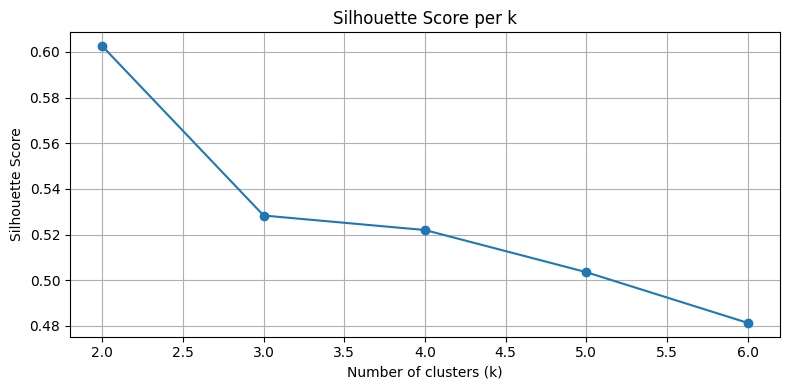

In [37]:
silhouette_scores(X, k_min=2, k_max=6)

In [133]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X)

In [78]:
df_cluster.head()

,unique_id,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv,cluster
0,10002 | FRANCE,44.000000,12.0,62.571003,0.0,228.0,0.500000,1.422068,1
24,10002 | GERMANY,9.863636,0.0,24.999610,0.0,96.0,0.727273,2.534523,1
46,10002 | ITALY,17.142857,0.0,65.679742,0.0,300.0,0.857143,3.831318,0
67,10002 | SPAIN,4.000000,0.0,11.001976,0.0,48.0,0.833333,2.750494,0
91,10002 | SWITZERLAND,6.315789,0.0,22.043020,0.0,96.0,0.842105,3.490145,0


In [42]:
df_cluster.groupby('cluster').describe().T

cluster                                 0            1             2
quantity_mean         count   2840.000000  3090.000000   1664.000000
                      mean      10.105764    15.826438    229.292128
                      std       43.239786    33.613061    383.497002
                      min        0.062500     0.600000      1.846154
                      25%        1.090909     3.600000     28.583333
                      50%        1.846154     6.461538    112.023810
                      75%        4.173913    14.000000    260.166667
                      max     1094.086957   937.625000   6988.818182
quantity_median       count   2840.000000  3090.000000   1664.000000
                      mean       0.005106     1.892880    176.829928
                      std        0.147989     9.945327    309.052374
                      min        0.000000     0.000000      1.000000
                      25%        0.000000     0.000000     20.000000
                      50%        0.000000     0.000000     72.000000
                      75%        0.000000     0.000000    192.000000
                      max        6.000000   288.000000   3943.000000
quantity_std_dev      count   2840.000000  3090.000000   1664.000000
                      mean      39.535022    29.147380    195.743351
                      std      187.073467    57.903737    613.168317
                      min        0.250000     1.258306      0.000000
                      25%        3.618136     6.592886     29.337452
                      50%        6.454972    12.000000    101.503627
                      75%       13.856406    26.054555    213.081506
                      max     4130.879522  1091.067639  22297.532746
quantity_min          count   2840.000000  3090.000000   1664.000000
                      mean       0.000000     0.000000     43.053486
                      std        0.000000     0.000000    128.192519
                      min        0.000000     0.000000      0.000000
                      25%        0.000000     0.000000      0.000000
                      50%        0.000000     0.000000      0.000000
                      75%        0.000000     0.000000     27.000000
                      max        0.000000     0.000000   1619.000000
quantity_max          count   2840.000000  3090.000000   1664.000000
                      mean     168.220070    92.520388    752.351562
                      std      859.109871   210.245052   2144.976814
                      min        1.000000     4.000000      4.000000
                      25%       12.000000    20.000000     96.000000
                      50%       24.000000    36.000000    385.500000
                      75%       48.000000    87.500000    832.250000
                      max    19152.000000  4752.000000  74215.000000
missing_quantity_mean count   2840.000000  3090.000000   1664.000000
                      mean       0.898053     0.679187      0.116414
                      std        0.052946     0.121217      0.138494
                      min        0.291667     0.250000      0.000000
                      25%        0.866667     0.600000      0.000000
                      50%        0.909091     0.714286      0.041667
                      75%        0.933333     0.777778      0.250000
                      max        0.958333     0.850000      0.416667
quantity_cv           count   2840.000000  3090.000000   1664.000000
                      mean       3.548138     1.926915      0.964211
                      std        0.667439     0.420310      0.459954
                      min        2.509980     0.968246      0.000000
                      25%        3.000000     1.594413      0.652830
                      50%        3.464102     1.984313      0.903165
                      75%        4.000000     2.236068      1.171922
                      max        4.898979     3.837780      4.289225

In [134]:
train = pd.merge(train, df_cluster[['unique_id', 'cluster']], how='left', on='unique_id')

In [138]:
test = pd.merge(test, df_cluster[['unique_id', 'cluster']], how='left', on='unique_id')

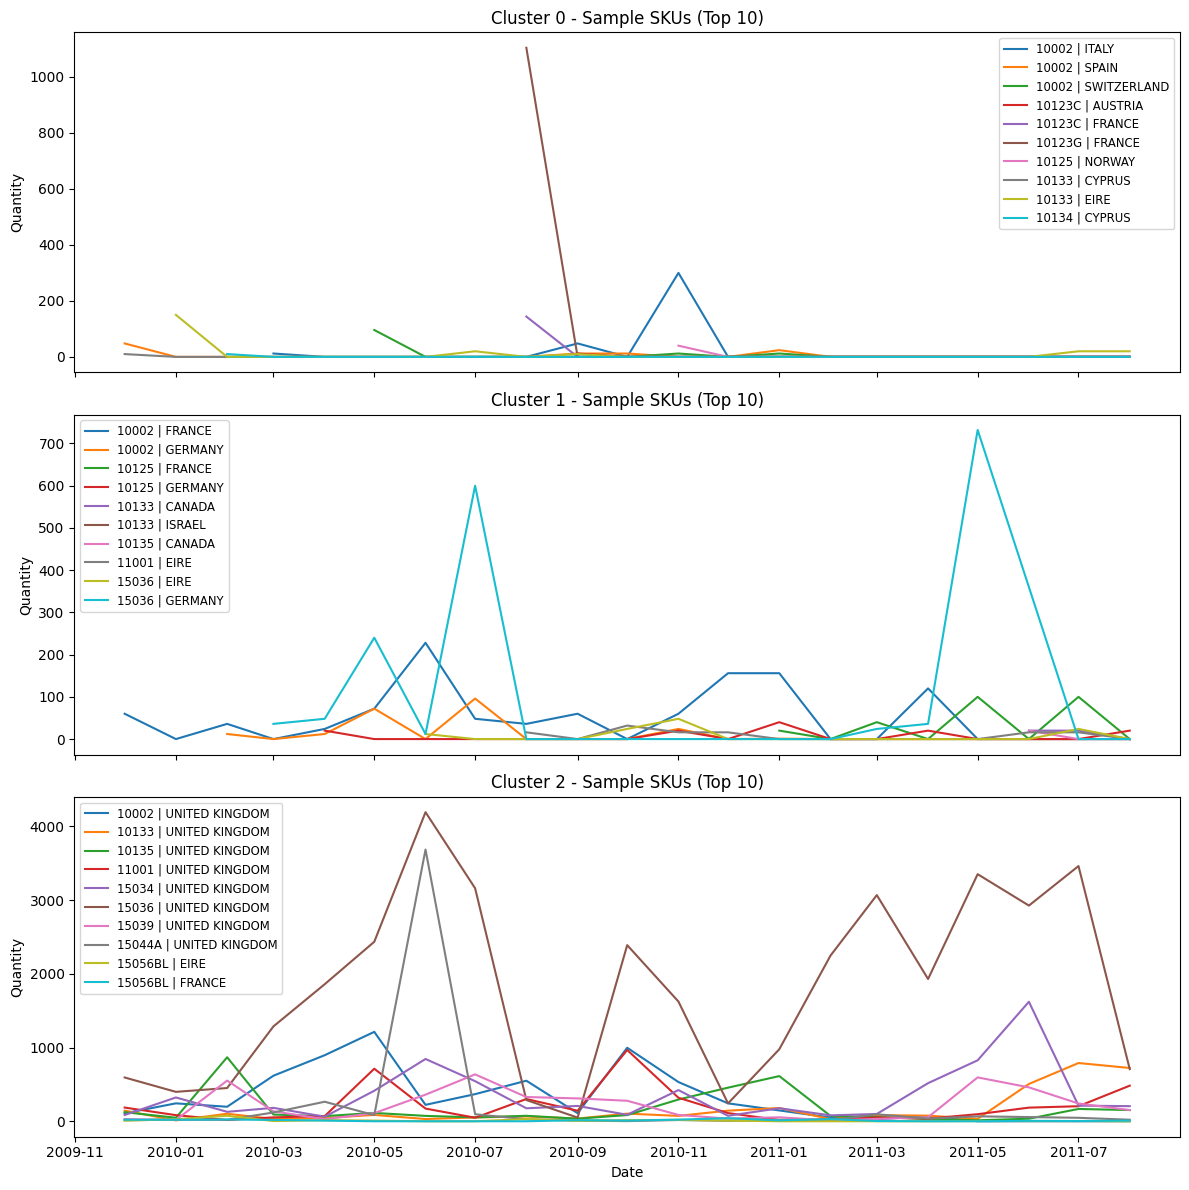

In [45]:
import matplotlib.pyplot as plt


# Get number of clusters
n_clusters = train['cluster'].nunique()
fig, axs = plt.subplots(n_clusters, 1, figsize=(12, 4 * n_clusters), sharex=True)

for i in range(n_clusters):
    ax = axs[i] if n_clusters > 1 else axs
    cluster_df = train[train['cluster'] == i]
    
    # Get first 5 unique SKUs in this cluster
    unique_ids = cluster_df['unique_id'].unique()[:10]

    for uid in unique_ids:
        sku_df = cluster_df[cluster_df['unique_id'] == uid].sort_values('ds')
        ax.plot(sku_df['ds'], sku_df['quantity'], label=uid)

    ax.set_title(f"Cluster {i} - Sample SKUs (Top 10)")
    ax.set_ylabel("Quantity")
    ax.legend(fontsize='small')

plt.xlabel("Date")
plt.tight_layout()
plt.show()


# Training Model

## Random Forest + MLForecast

In [135]:
cluster2 = train[train['cluster'] == 2].copy()

In [136]:
cluster2.rename(columns={'quantity':'y'}, inplace=True)

In [82]:
cluster2.head()

,unique_id,sku_id,country,ds,y,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv,cluster
95,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2009-12-01,108.0,94.35,17.0,13.0,0.873611,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2
96,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2010-01-01,243.0,208.17,16.0,14.0,0.856667,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2
97,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2010-02-01,197.0,169.07,10.0,8.0,0.858223,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2
98,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2010-03-01,618.0,473.54,15.0,13.0,0.766246,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2
99,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2010-04-01,896.0,669.13,21.0,17.0,0.746797,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2


In [83]:
cluster2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24436 entries, 95 to 98050
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   unique_id              24436 non-null  object        
 1   sku_id                 24436 non-null  object        
 2   country                24436 non-null  object        
 3   ds                     24436 non-null  datetime64[ns]
 4   y                      24436 non-null  float64       
 5   gmv                    24436 non-null  float64       
 6   total_order            24436 non-null  float64       
 7   total_customer         24436 non-null  float64       
 8   price                  24436 non-null  float64       
 9   missing_quantity       24436 non-null  bool          
 10  quantity_count         24436 non-null  int64         
 11  quantity_mean          24436 non-null  float64       
 12  quantity_median        24436 non-null  float64       
 13  quant

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

In [91]:
mforc = MLForecast(
    models={'rf': rf},
    freq='MS',                     # monthly start
    lags=[1, 3],            # lag bulanan
    date_features=['month', 'year', 'quarter'],
    num_threads=1,
    target_transforms=[Differences([1])]  # optional
)

In [85]:
cluster2.head()

,unique_id,sku_id,country,ds,y,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv,cluster
95,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2009-12-01,108.0,94.35,17.0,13.0,0.873611,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2
96,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2010-01-01,243.0,208.17,16.0,14.0,0.856667,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2
97,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2010-02-01,197.0,169.07,10.0,8.0,0.858223,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2
98,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2010-03-01,618.0,473.54,15.0,13.0,0.766246,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2
99,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2010-04-01,896.0,669.13,21.0,17.0,0.746797,False,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2


In [93]:
mforc.fit(
    cluster2[['unique_id', 'ds', 'y']],
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[],
    dropna=False
)

c:\Users\User\Documents\GitHub\kalbe-python-workshop-2025\.venv\lib\site-packages\mlforecast\core.py:434: UserWarning: The following series were dropped completely due to the transformations and features: ['16169E | GERMANY', '21039 | SWITZERLAND', '22720 | NORWAY', '22964 | NORWAY', '22979 | NORWAY', '22982 | NORWAY', ...].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(


MLForecast(models=[rf], freq=MS, lag_features=['lag1', 'lag3'], date_features=['month', 'year', 'quarter'], num_threads=1)

In [119]:
test.rename(columns={'quantity':'y'}, inplace=True)

In [107]:
test.head()

,unique_id,sku_id,country,ds,y,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
189,10125 | FRANCE,10125,FRANCE,2011-09-01,150.0,127.50,1.0,1.0,0.850000,False,11,42.727273,20.0,52.932204,0.0,150.0,0.454545,1.238839
191,10125 | FRANCE,10125,FRANCE,2011-11-01,60.0,51.00,1.0,1.0,0.850000,False,11,42.727273,20.0,52.932204,0.0,150.0,0.454545,1.238839
210,10125 | GERMANY,10125,GERMANY,2011-10-01,20.0,17.00,1.0,1.0,0.850000,False,20,7.000000,0.0,11.742859,0.0,40.0,0.700000,1.677551
303,10133 | UNITED KINGDOM,10133,UNITED KINGDOM,2011-09-01,207.0,92.27,9.0,5.0,0.445749,False,24,148.000000,74.5,214.147247,0.0,790.0,0.083333,1.446941
398,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2011-09-01,70.0,99.60,11.0,8.0,1.422857,False,24,159.750000,73.5,206.189708,13.0,868.0,0.000000,1.290702


In [113]:
missing = mforc.get_missing_future(3, X_df=test[['unique_id','ds','price']])
print(missing)

Empty DataFrame
Columns: [unique_id, ds]
Index: []


In [139]:
test2 = test[test.cluster == 2]

In [140]:
preds = mforc.predict(3, X_df=test2[['unique_id','ds','price']])

# ambil salah satu model sebagai yhat
preds = preds.rename(columns={'rf': 'yhat'})

c:\Users\User\Documents\GitHub\kalbe-python-workshop-2025\.venv\lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag1, lag3.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
c:\Users\User\Documents\GitHub\kalbe-python-workshop-2025\.venv\lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag3.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
c:\Users\User\Documents\GitHub\kalbe-python-workshop-2025\.venv\lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag3.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


In [141]:
preds

,unique_id,ds,yhat
0,10002 | UNITED KINGDOM,2011-09-01,30.817826
1,10002 | UNITED KINGDOM,2011-10-01,50.576281
2,10002 | UNITED KINGDOM,2011-11-01,71.049825
3,10133 | UNITED KINGDOM,2011-09-01,777.878940
4,10133 | UNITED KINGDOM,2011-10-01,795.485975
...,...,...,...
4987,85231B | UNITED KINGDOM,2011-10-01,82.474273
4988,85231B | UNITED KINGDOM,2011-11-01,103.102736
4989,C2 | EIRE,2011-09-01,37.451279
4990,C2 | EIRE,2011-10-01,57.209734


In [142]:
merged = test2.merge(preds[['unique_id','ds','yhat']], on=['unique_id','ds'], how='left')

In [143]:
merged.head()

,unique_id,sku_id,country,ds,y,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv,cluster,yhat
0,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2011-09-01,0.0,0.00,0.0,0.0,0.850000,True,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2.0,30.817826
1,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2011-10-01,0.0,0.00,0.0,0.0,0.850000,True,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2.0,50.576281
2,10002 | UNITED KINGDOM,10002,UNITED KINGDOM,2011-11-01,0.0,0.00,0.0,0.0,0.850000,True,24,274.708333,128.5,350.159526,0.0,1213.0,0.291667,1.274659,2.0,71.049825
3,10133 | UNITED KINGDOM,10133,UNITED KINGDOM,2011-09-01,207.0,92.27,9.0,5.0,0.445749,False,24,148.000000,74.5,214.147247,0.0,790.0,0.083333,1.446941,2.0,777.878940
4,10133 | UNITED KINGDOM,10133,UNITED KINGDOM,2011-10-01,0.0,0.00,0.0,0.0,0.445749,True,24,148.000000,74.5,214.147247,0.0,790.0,0.083333,1.446941,2.0,795.485975


In [144]:
merged.fillna(0, inplace=True)

In [145]:

print({
    'MSE': mean_squared_error(merged['y'], merged['yhat']),
    'MAE': mean_absolute_error(merged['y'], merged['yhat']),
    'MAPE(%)': mean_absolute_percentage_error(merged['y'], merged['yhat']) * 100
})

{'MSE': 149224.83221377307, 'MAE': 171.33300386511013, 'MAPE(%)': 6.497981685931903e+18}


Text(0.5, 1.0, 'Series: 10133 | UNITED KINGDOM')

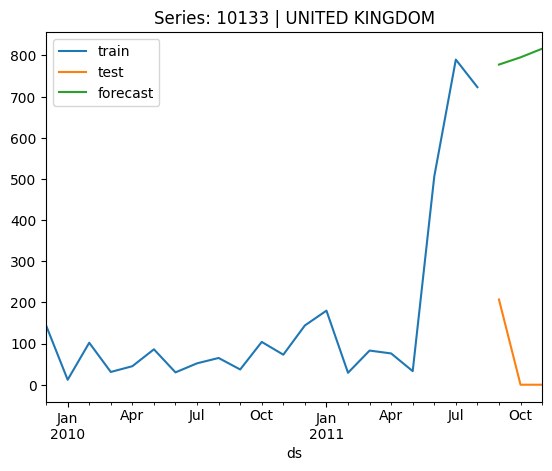

In [147]:
sample_id = merged.unique_id.iloc[3]
plot_train = cluster2[cluster2.unique_id==sample_id][['ds','y']].set_index('ds')
plot_test  = merged[merged.unique_id==sample_id][['ds','y']].set_index('ds')
plot_pred  = merged[merged.unique_id==sample_id][['ds','yhat']].set_index('ds')

ax = plot_train['y'].plot(label='train')
plot_test['y'].plot(ax=ax, label='test')
plot_pred['yhat'].plot(ax=ax, label='forecast')
ax.legend(); ax.set_title(f'Series: {sample_id}')